# CNN-Speech Classifier
This is a notebook to train CNN model

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import sys

import matplotlib.pyplot as plt
import IPython.display as ipd

from tqdm import tqdm

show a waveform sample

tensor([[0., 0., 0.,  ..., 0., 0., 0.]])


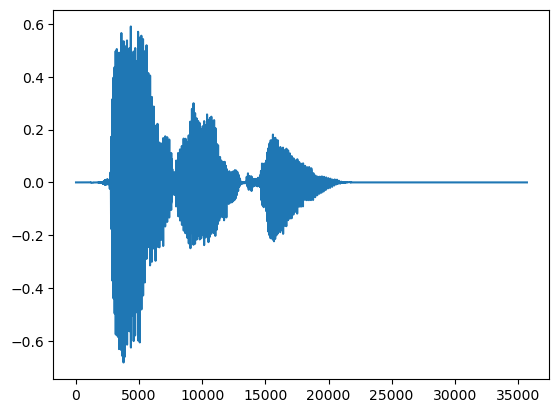

In [32]:
import os

DatasetFilePath = "/Users/xuhuan/Desktop/voicement desensitization/TextDataset/VoiceData"
waveform, sr = torchaudio.load(filepath=DatasetFilePath + "/sensitive/0.wav", frame_offset=0 , num_frames=-1, normalize=True, channels_first=True)
print(waveform)
plt.plot(waveform.t().numpy())

## Importing the dataset

In [33]:
X = []
y = []
NonDatasetFilePath = "/Users/xuhuan/Desktop/voicement desensitization/TextDataset/VoiceData/nonsensitive"
SenDatasetFilePath = "/Users/xuhuan/Desktop/voicement desensitization/TextDataset/VoiceData/sensitive"
for root, dirs, files in os.walk(NonDatasetFilePath):
    for f in files:
        if f.endswith(".wav"):
            waveform, sr = torchaudio.load(filepath=(NonDatasetFilePath + "/" + f), frame_offset=0 , num_frames=-1, normalize=True, channels_first=True)
            X.append(waveform)
            y.append("nonsensitive")
for root, dirs, files in os.walk(SenDatasetFilePath):
    for f in files:
        if f.endswith(".wav"):
            waveform, sr = torchaudio.load(filepath=(SenDatasetFilePath + "/" + f), frame_offset=0 , num_frames=-1, normalize=True, channels_first=True)
            X.append(waveform)
            y.append("sensitive")
            # X.append(waveform)
            # y.append("sensitive")
NumberofSensitiveData = y.count('sensitive')
print('There are %d sensitive data' % NumberofSensitiveData)
print('There are %d nonsensitive data' % (len(y) - NumberofSensitiveData))

There are 316 sensitive data
There are 342 nonsensitive data


Divide dataset into training set and testing set

In [34]:
from sklearn import model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

526
132


In [36]:
import torch
from torch.utils.data import Dataset


class TensorDataset(Dataset):
    def __init__(self, data_tensor, target_tensor):
        self.data_tensor = data_tensor
        self.target_tensor = target_tensor

    def __getitem__(self, index):
        return self.data_tensor[index], self.target_tensor[index]

    def __len__(self):
        return len(self.data_tensor)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# get the size of the dataset
print(len(train_dataset))
print(len(test_dataset))



526
132


In [37]:
labels = sorted(list(set(datapoint[1] for datapoint in train_dataset)))
labels

['nonsensitive', 'sensitive']

## Formatting Data
This is a good place to apply transformations to the data. For the waveform, we downsample the audio for faster processing without losing too much of the classification power.

In [38]:
new_sample_rate = 8000
transform = torchaudio.transforms.Resample(new_freq=new_sample_rate)
transformed = transform(waveform)

ipd.Audio(transformed.numpy(), rate=new_sample_rate)

In [39]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]


word_start = "sensitive"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

sensitive --> tensor(1) --> sensitive


In [40]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, label in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 1
num_workers = 0

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=False,
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=False,
)
# for data, target in train_loader:
#     print(data, target)

## Create CNN Model

In [41]:
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.conv5 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn5 = nn.BatchNorm1d(2 * n_channel)
        self.pool5 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)


model = M5(n_input=transformed.shape[0], n_output=len(labels))
model.to(device)
print(model)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(model)
print("Number of parameters: %s" % n)

M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn5): B

In [42]:
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10

In [43]:
def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)
        #print(output.squeeze(), target)
        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        loss = F.nll_loss(torch.squeeze(output, dim=0), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # update progress bar
        pbar.update(pbar_update)
        # record loss
        losses.append(loss.item())

In [44]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

        # update progress bar
        pbar.update(pbar_update)

    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n")

In [45]:
log_interval = 20
n_epoch = 2

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []

# The transform needs to live on the same device as the model and the data.
transform = transform.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)
        test(model, epoch)
        scheduler.step()

# Let's plot the training loss versus the number of iteration.
# plt.plot(losses);
# plt.title("training loss");

  0%|          | 0/2 [00:00<?, ?it/s]

Train Epoch: 1 [0/526 (0%)]	Loss: 0.993220


  2%|▏         | 0.031914893617021274/2 [00:00<00:06,  3.25s/it]

Train Epoch: 1 [20/526 (4%)]	Loss: 0.437610
Train Epoch: 1 [40/526 (8%)]	Loss: 0.754593


  5%|▍         | 0.09422492401215805/2 [00:00<00:06,  3.45s/it] 

Train Epoch: 1 [60/526 (11%)]	Loss: 0.288686


  6%|▌         | 0.12462006079027356/2 [00:00<00:06,  3.51s/it]

Train Epoch: 1 [80/526 (15%)]	Loss: 0.320126


  8%|▊         | 0.15653495440729456/2 [00:00<00:06,  3.41s/it]

Train Epoch: 1 [100/526 (19%)]	Loss: 0.605200


  9%|▉         | 0.1869300911854098/2 [00:00<00:06,  3.41s/it] 

Train Epoch: 1 [120/526 (23%)]	Loss: 0.711084


 11%|█         | 0.21732522796352502/2 [00:00<00:06,  3.43s/it]

Train Epoch: 1 [140/526 (27%)]	Loss: 0.362877


 12%|█▏        | 0.24772036474164025/2 [00:00<00:06,  3.98s/it]

Train Epoch: 1 [160/526 (30%)]	Loss: 1.727395


 14%|█▍        | 0.275075987841944/2 [00:01<00:06,  4.01s/it]  

Train Epoch: 1 [180/526 (34%)]	Loss: 0.969141


 15%|█▌        | 0.3009118541033419/2 [00:01<00:06,  4.05s/it]

Train Epoch: 1 [200/526 (38%)]	Loss: 0.840156


 18%|█▊        | 0.3571428571428551/2 [00:01<00:06,  3.85s/it]

Train Epoch: 1 [220/526 (42%)]	Loss: 0.402760


 19%|█▉        | 0.3844984802431588/2 [00:01<00:06,  3.83s/it]

Train Epoch: 1 [240/526 (46%)]	Loss: 1.524038


 21%|██        | 0.4164133738601798/2 [00:01<00:05,  3.65s/it]

Train Epoch: 1 [260/526 (49%)]	Loss: 0.856793


 22%|██▏       | 0.446808510638295/2 [00:01<00:05,  3.59s/it] 

Train Epoch: 1 [280/526 (53%)]	Loss: 0.532558


 24%|██▍       | 0.4756838905775045/2 [00:01<00:05,  3.61s/it]

Train Epoch: 1 [300/526 (57%)]	Loss: 1.060498


 25%|██▌       | 0.5045592705167141/2 [00:01<00:05,  3.65s/it]

Train Epoch: 1 [320/526 (61%)]	Loss: 0.754085


 27%|██▋       | 0.5349544072948305/2 [00:01<00:05,  3.55s/it]

Train Epoch: 1 [340/526 (65%)]	Loss: 0.750332


 28%|██▊       | 0.563829787234041/2 [00:02<00:05,  3.59s/it] 

Train Epoch: 1 [360/526 (68%)]	Loss: 0.908845
Train Epoch: 1 [380/526 (72%)]	Loss: 0.911080


 31%|███       | 0.6231003039513678/2 [00:02<00:05,  3.83s/it]

Train Epoch: 1 [400/526 (76%)]	Loss: 0.715929


 33%|███▎      | 0.6565349544072958/2 [00:02<00:04,  3.61s/it]

Train Epoch: 1 [420/526 (80%)]	Loss: 0.544396
Train Epoch: 1 [440/526 (84%)]	Loss: 0.562680


 34%|███▍      | 0.6869300911854122/2 [00:02<00:04,  3.52s/it]

Train Epoch: 1 [460/526 (87%)]	Loss: 1.134157


 37%|███▋      | 0.7446808510638332/2 [00:02<00:04,  3.51s/it]

Train Epoch: 1 [480/526 (91%)]	Loss: 0.899459


 39%|███▉      | 0.7750759878419495/2 [00:02<00:04,  3.47s/it]

Train Epoch: 1 [500/526 (95%)]	Loss: 0.694534


 40%|████      | 0.8085106382978775/2 [00:02<00:03,  3.33s/it]

Train Epoch: 1 [520/526 (99%)]	Loss: 0.452088


 53%|█████▎    | 1.0577507598784315/2 [00:03<00:02,  2.26s/it]


Test Epoch: 1	Accuracy: 59/132 (45%)

Train Epoch: 2 [0/526 (0%)]	Loss: 0.518442
Train Epoch: 2 [20/526 (4%)]	Loss: 0.714763
Train Epoch: 2 [40/526 (8%)]	Loss: 0.496155


 57%|█████▋    | 1.1458966565349689/2 [00:03<00:02,  2.78s/it]

Train Epoch: 2 [60/526 (11%)]	Loss: 0.718382
Train Epoch: 2 [80/526 (15%)]	Loss: 0.256261
Train Epoch: 2 [100/526 (19%)]	Loss: 0.722520


 61%|██████    | 1.220364741641354/2 [00:03<00:02,  2.96s/it] 

Train Epoch: 2 [120/526 (23%)]	Loss: 0.954868
Train Epoch: 2 [140/526 (27%)]	Loss: 0.721029
Train Epoch: 2 [160/526 (30%)]	Loss: 0.614520


 66%|██████▋   | 1.328267477203667/2 [00:04<00:01,  2.96s/it] 

Train Epoch: 2 [180/526 (34%)]	Loss: 0.556570
Train Epoch: 2 [200/526 (38%)]	Loss: 0.607900
Train Epoch: 2 [220/526 (42%)]	Loss: 0.658359


 70%|██████▉   | 1.3966565349544287/2 [00:04<00:01,  3.09s/it]

Train Epoch: 2 [240/526 (46%)]	Loss: 0.556572
Train Epoch: 2 [260/526 (49%)]	Loss: 0.806790
Train Epoch: 2 [280/526 (53%)]	Loss: 0.892302


 75%|███████▍  | 1.4984802431611184/2 [00:04<00:01,  3.21s/it]

Train Epoch: 2 [300/526 (57%)]	Loss: 0.612091
Train Epoch: 2 [320/526 (61%)]	Loss: 0.768865


 78%|███████▊  | 1.5607902735562569/2 [00:05<00:01,  3.42s/it]

Train Epoch: 2 [340/526 (65%)]	Loss: 0.630857
Train Epoch: 2 [360/526 (68%)]	Loss: 0.453576


 81%|████████  | 1.6215805471124896/2 [00:05<00:01,  3.39s/it]

Train Epoch: 2 [380/526 (72%)]	Loss: 0.881127
Train Epoch: 2 [400/526 (76%)]	Loss: 0.759451


 84%|████████▍ | 1.6823708206687222/2 [00:05<00:01,  3.46s/it]

Train Epoch: 2 [420/526 (80%)]	Loss: 0.610934
Train Epoch: 2 [440/526 (84%)]	Loss: 0.738718


 87%|████████▋ | 1.7446808510638607/2 [00:05<00:00,  3.38s/it]

Train Epoch: 2 [460/526 (87%)]	Loss: 0.642679
Train Epoch: 2 [480/526 (91%)]	Loss: 1.084880
Train Epoch: 2 [500/526 (95%)]	Loss: 0.857706


 94%|█████████▎| 1.8723404255319493/2 [00:05<00:00,  2.53s/it]

Train Epoch: 2 [520/526 (99%)]	Loss: 1.104203


 97%|█████████▋| 1.9376899696048995/2 [00:06<00:00,  2.13s/it]/Users/xuhuan/opt/anaconda3/envs/python37/lib/python3.7/site-packages/tqdm/std.py:536: TqdmWarning: clamping frac to range [0, 1]
  colour=colour)
100%|██████████| 2.0000000000000377/2 [00:06<00:00,  3.09s/it]


Test Epoch: 2	Accuracy: 61/132 (46%)

